# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [102]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [104]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [105]:
#TODO: Implement gradient check function
def sqr(x):
    return x*x, 2*x

check_gradient(sqr, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [107]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [108]:
probs = linear_classifer.softmax(np.array([[-5, 0, 5]]))
linear_classifer.cross_entropy_loss(probs, [1])

5.006760443547121

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [110]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([[1, 0, 0]]), [1])
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([[1, 0, 0]], np.float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [111]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=batch_size).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=batch_size).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

Gradient check passed!


True

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [118]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [119]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [120]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=10)

Epoch 0, loss: 2.397363
Epoch 1, loss: 2.330354
Epoch 2, loss: 2.311002
Epoch 3, loss: 2.303897
Epoch 4, loss: 2.303257
Epoch 5, loss: 2.302898
Epoch 6, loss: 2.302564
Epoch 7, loss: 2.301815
Epoch 8, loss: 2.301252
Epoch 9, loss: 2.301256


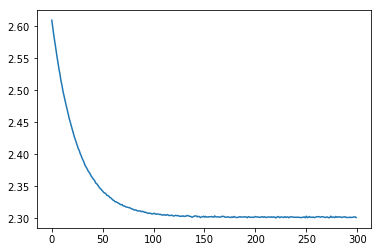

In [121]:
# let's look at the loss history!
plt.plot(loss_history)

In [721]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.151
Epoch 0, loss: 2.302725
Epoch 1, loss: 2.302791
Epoch 2, loss: 2.301357
Epoch 3, loss: 2.301276
Epoch 4, loss: 2.302099
Epoch 5, loss: 2.301970
Epoch 6, loss: 2.302318
Epoch 7, loss: 2.301796
Epoch 8, loss: 2.302969
Epoch 9, loss: 2.301831
Epoch 10, loss: 2.301928
Epoch 11, loss: 2.302432
Epoch 12, loss: 2.301526
Epoch 13, loss: 2.301444
Epoch 14, loss: 2.302172
Epoch 15, loss: 2.301620
Epoch 16, loss: 2.302301
Epoch 17, loss: 2.301777
Epoch 18, loss: 2.302078
Epoch 19, loss: 2.301977
Epoch 20, loss: 2.301629
Epoch 21, loss: 2.302418
Epoch 22, loss: 2.302278
Epoch 23, loss: 2.301742
Epoch 24, loss: 2.302121
Epoch 25, loss: 2.301680
Epoch 26, loss: 2.302512
Epoch 27, loss: 2.301754
Epoch 28, loss: 2.302120
Epoch 29, loss: 2.302805
Epoch 30, loss: 2.302384
Epoch 31, loss: 2.301618
Epoch 32, loss: 2.301947
Epoch 33, loss: 2.301429
Epoch 34, loss: 2.302169
Epoch 35, loss: 2.302310
Epoch 36, loss: 2.302223
Epoch 37, loss: 2.302167
Epoch 38, loss: 2.301510
Epoch 39, loss: 2.

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [722]:
%%time
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = 0
best_hyper = None

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially

for lr in learning_rates:
    for rs in reg_strengths:
        classifier = linear_classifer.LinearSoftmaxClassifier()
        classifier.fit(train_X, train_y, epochs=num_epochs, learning_rate=lr, batch_size=batch_size, reg=rs)
        pred = classifier.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)
        if accuracy > best_val_accuracy:
            best_val_accuracy = accuracy
            best_classifier = classifier
            best_hyper = [lr, rs]

Epoch 0, loss: 2.302072
Epoch 1, loss: 2.301252
Epoch 2, loss: 2.298745
Epoch 3, loss: 2.300135
Epoch 4, loss: 2.300572
Epoch 5, loss: 2.296620
Epoch 6, loss: 2.295507
Epoch 7, loss: 2.297866
Epoch 8, loss: 2.292782
Epoch 9, loss: 2.296167
Epoch 10, loss: 2.294574
Epoch 11, loss: 2.292713
Epoch 12, loss: 2.293354
Epoch 13, loss: 2.291753
Epoch 14, loss: 2.288502
Epoch 15, loss: 2.290252
Epoch 16, loss: 2.289301
Epoch 17, loss: 2.284615
Epoch 18, loss: 2.287594
Epoch 19, loss: 2.289355
Epoch 20, loss: 2.286312
Epoch 21, loss: 2.287539
Epoch 22, loss: 2.283076
Epoch 23, loss: 2.286043
Epoch 24, loss: 2.279854
Epoch 25, loss: 2.283448
Epoch 26, loss: 2.283372
Epoch 27, loss: 2.287461
Epoch 28, loss: 2.274858
Epoch 29, loss: 2.279832
Epoch 30, loss: 2.284169
Epoch 31, loss: 2.272767
Epoch 32, loss: 2.274322
Epoch 33, loss: 2.272513
Epoch 34, loss: 2.278540
Epoch 35, loss: 2.282478
Epoch 36, loss: 2.269291
Epoch 37, loss: 2.272107
Epoch 38, loss: 2.279555
Epoch 39, loss: 2.273525
Epoch 40, 

Epoch 124, loss: 2.234536
Epoch 125, loss: 2.227084
Epoch 126, loss: 2.227421
Epoch 127, loss: 2.221553
Epoch 128, loss: 2.212068
Epoch 129, loss: 2.235508
Epoch 130, loss: 2.238055
Epoch 131, loss: 2.235050
Epoch 132, loss: 2.225560
Epoch 133, loss: 2.214029
Epoch 134, loss: 2.234035
Epoch 135, loss: 2.243711
Epoch 136, loss: 2.218825
Epoch 137, loss: 2.222974
Epoch 138, loss: 2.195035
Epoch 139, loss: 2.234761
Epoch 140, loss: 2.251964
Epoch 141, loss: 2.216085
Epoch 142, loss: 2.229043
Epoch 143, loss: 2.222980
Epoch 144, loss: 2.202988
Epoch 145, loss: 2.244413
Epoch 146, loss: 2.215938
Epoch 147, loss: 2.235343
Epoch 148, loss: 2.230762
Epoch 149, loss: 2.236344
Epoch 150, loss: 2.233491
Epoch 151, loss: 2.228373
Epoch 152, loss: 2.209909
Epoch 153, loss: 2.209120
Epoch 154, loss: 2.207140
Epoch 155, loss: 2.211965
Epoch 156, loss: 2.213359
Epoch 157, loss: 2.220014
Epoch 158, loss: 2.219101
Epoch 159, loss: 2.237951
Epoch 160, loss: 2.227035
Epoch 161, loss: 2.216053
Epoch 162, l

Epoch 47, loss: 2.298353
Epoch 48, loss: 2.298201
Epoch 49, loss: 2.298952
Epoch 50, loss: 2.299585
Epoch 51, loss: 2.299979
Epoch 52, loss: 2.295972
Epoch 53, loss: 2.296419
Epoch 54, loss: 2.296676
Epoch 55, loss: 2.299275
Epoch 56, loss: 2.296703
Epoch 57, loss: 2.300092
Epoch 58, loss: 2.298896
Epoch 59, loss: 2.296449
Epoch 60, loss: 2.299008
Epoch 61, loss: 2.297185
Epoch 62, loss: 2.296383
Epoch 63, loss: 2.297521
Epoch 64, loss: 2.295990
Epoch 65, loss: 2.298930
Epoch 66, loss: 2.298239
Epoch 67, loss: 2.295391
Epoch 68, loss: 2.297550
Epoch 69, loss: 2.298679
Epoch 70, loss: 2.297746
Epoch 71, loss: 2.298239
Epoch 72, loss: 2.296278
Epoch 73, loss: 2.295000
Epoch 74, loss: 2.297676
Epoch 75, loss: 2.295578
Epoch 76, loss: 2.296751
Epoch 77, loss: 2.298036
Epoch 78, loss: 2.295497
Epoch 79, loss: 2.295390
Epoch 80, loss: 2.296022
Epoch 81, loss: 2.296421
Epoch 82, loss: 2.293863
Epoch 83, loss: 2.296219
Epoch 84, loss: 2.296920
Epoch 85, loss: 2.297250
Epoch 86, loss: 2.293474


Epoch 170, loss: 2.288999
Epoch 171, loss: 2.286994
Epoch 172, loss: 2.290162
Epoch 173, loss: 2.288366
Epoch 174, loss: 2.288863
Epoch 175, loss: 2.284760
Epoch 176, loss: 2.291873
Epoch 177, loss: 2.290572
Epoch 178, loss: 2.288893
Epoch 179, loss: 2.291316
Epoch 180, loss: 2.288525
Epoch 181, loss: 2.285751
Epoch 182, loss: 2.283730
Epoch 183, loss: 2.288425
Epoch 184, loss: 2.287366
Epoch 185, loss: 2.285907
Epoch 186, loss: 2.289882
Epoch 187, loss: 2.290835
Epoch 188, loss: 2.290970
Epoch 189, loss: 2.290120
Epoch 190, loss: 2.287258
Epoch 191, loss: 2.285749
Epoch 192, loss: 2.282709
Epoch 193, loss: 2.288870
Epoch 194, loss: 2.286760
Epoch 195, loss: 2.286847
Epoch 196, loss: 2.284786
Epoch 197, loss: 2.287357
Epoch 198, loss: 2.290482
Epoch 199, loss: 2.282610
Epoch 0, loss: 2.303970
Epoch 1, loss: 2.301961
Epoch 2, loss: 2.303042
Epoch 3, loss: 2.302859
Epoch 4, loss: 2.301889
Epoch 5, loss: 2.301754
Epoch 6, loss: 2.302501
Epoch 7, loss: 2.301970
Epoch 8, loss: 2.302477
Epoc

Epoch 95, loss: 2.301603
Epoch 96, loss: 2.300768
Epoch 97, loss: 2.302235
Epoch 98, loss: 2.301541
Epoch 99, loss: 2.302070
Epoch 100, loss: 2.301013
Epoch 101, loss: 2.301631
Epoch 102, loss: 2.301555
Epoch 103, loss: 2.300567
Epoch 104, loss: 2.301724
Epoch 105, loss: 2.302443
Epoch 106, loss: 2.301831
Epoch 107, loss: 2.301877
Epoch 108, loss: 2.302070
Epoch 109, loss: 2.302094
Epoch 110, loss: 2.301200
Epoch 111, loss: 2.300394
Epoch 112, loss: 2.301580
Epoch 113, loss: 2.301938
Epoch 114, loss: 2.300243
Epoch 115, loss: 2.301096
Epoch 116, loss: 2.300993
Epoch 117, loss: 2.301207
Epoch 118, loss: 2.301594
Epoch 119, loss: 2.301730
Epoch 120, loss: 2.301931
Epoch 121, loss: 2.300632
Epoch 122, loss: 2.302252
Epoch 123, loss: 2.302188
Epoch 124, loss: 2.301012
Epoch 125, loss: 2.302560
Epoch 126, loss: 2.301908
Epoch 127, loss: 2.302056
Epoch 128, loss: 2.302055
Epoch 129, loss: 2.302546
Epoch 130, loss: 2.301308
Epoch 131, loss: 2.301329
Epoch 132, loss: 2.301485
Epoch 133, loss: 

Epoch 16, loss: 2.302778
Epoch 17, loss: 2.302333
Epoch 18, loss: 2.302344
Epoch 19, loss: 2.303686
Epoch 20, loss: 2.302745
Epoch 21, loss: 2.301854
Epoch 22, loss: 2.302344
Epoch 23, loss: 2.302606
Epoch 24, loss: 2.302626
Epoch 25, loss: 2.302579
Epoch 26, loss: 2.303869
Epoch 27, loss: 2.301406
Epoch 28, loss: 2.302414
Epoch 29, loss: 2.303277
Epoch 30, loss: 2.302953
Epoch 31, loss: 2.301824
Epoch 32, loss: 2.303059
Epoch 33, loss: 2.303106
Epoch 34, loss: 2.301722
Epoch 35, loss: 2.301817
Epoch 36, loss: 2.302659
Epoch 37, loss: 2.302812
Epoch 38, loss: 2.302088
Epoch 39, loss: 2.301499
Epoch 40, loss: 2.302864
Epoch 41, loss: 2.303001
Epoch 42, loss: 2.302215
Epoch 43, loss: 2.302078
Epoch 44, loss: 2.302419
Epoch 45, loss: 2.302230
Epoch 46, loss: 2.301410
Epoch 47, loss: 2.302163
Epoch 48, loss: 2.302751
Epoch 49, loss: 2.302483
Epoch 50, loss: 2.302593
Epoch 51, loss: 2.303014
Epoch 52, loss: 2.302865
Epoch 53, loss: 2.301986
Epoch 54, loss: 2.302403
Epoch 55, loss: 2.301565


In [723]:
print('best validation accuracy achieved: %f' % best_val_accuracy)

best validation accuracy achieved: 0.225000


In [724]:
best_hyper

[0.001, 1e-05]

# Какой же точности мы добились на тестовых данных?

In [639]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.217000
